Welcome to your Personal Expense Tracker! 💰

   PERSONAL EXPENSE TRACKER
1. Add New Expense
2. View All Expenses
3. Category Breakdown (with chart)
4. Weekly & Monthly Analysis
5. Search/Filter Expenses
6. Exit Program
----------------------------------------

--- Weekly Spending Summary ---
2025-W38: $11240.00

--- Monthly Spending Summary ---
2025-09 (September): $11240.00


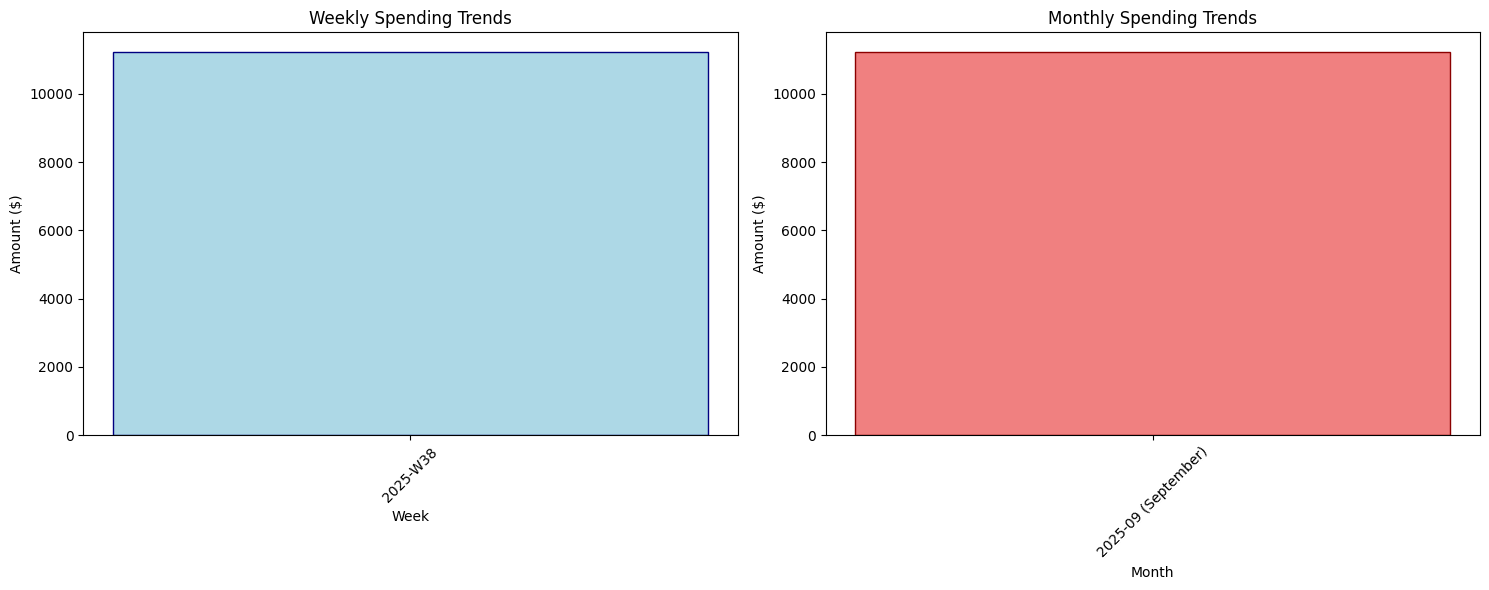


   PERSONAL EXPENSE TRACKER
1. Add New Expense
2. View All Expenses
3. Category Breakdown (with chart)
4. Weekly & Monthly Analysis
5. Search/Filter Expenses
6. Exit Program
----------------------------------------


In [ ]:
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt

# Database file name & Categories
db_file = "expenses.db"
expense_categories = ["Food", "Travel", "Study", "Other"]

def create_database():
    """Set up the database - only runs once but whatever, doesn't hurt to check"""
    connection = sqlite3.connect(db_file)
    cursor = connection.cursor()

    # Main table for storing expense data
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS expenses (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            date TEXT NOT NULL,
            category TEXT NOT NULL,
            amount REAL NOT NULL,
            note TEXT
        )
    """)
    connection.commit()
    connection.close()

def add_new_expense():
    """Add expense to database - with some input validation"""
    print("\n--- Adding New Expense ---")

    category_input = ""
    while True:
        category_input = input(f"Enter category from {expense_categories}: ").strip().capitalize()
        if category_input in expense_categories:
            break
        else:
            print("❌ Please choose from the available categories!")

    expense_amount = 0
    while True:
        try:
            expense_amount = float(input("Enter the amount spent: $"))
            if expense_amount <= 0:
                print("❌ Amount should be positive!")
                continue
            break
        except ValueError:
            print("❌ That's not a valid number. Try again.")


    user_note = input("Add a note (press Enter to skip): ").strip()

    # Timestamp
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    conn = sqlite3.connect(db_file)
    cur = conn.cursor()
    cur.execute("INSERT INTO expenses (date, category, amount, note) VALUES (?, ?, ?, ?)",
                (current_time, category_input, expense_amount, user_note))
    conn.commit()
    conn.close()

    print("✅ Expense saved successfully!")

def show_all_expenses():
    """Display all recorded expenses in a nice format"""
    conn = sqlite3.connect(db_file)
    cur = conn.cursor()
    cur.execute("SELECT * FROM expenses ORDER BY date DESC")
    all_expenses = cur.fetchall()
    conn.close()

    if len(all_expenses) == 0:
        print("❌ No expenses found. Start by adding some!")
        return

    print("\n--- Your Expense History ---")
    print("Date & Time          | Category | Amount  | Note")
    print("-" * 55)

    total_amount = 0.0
    for expense in all_expenses:
        expense_id, date_time, category, amount, note = expense
        # Display
        note_display = note if note else "No note"
        print(f"{date_time} | {category:8} | ${amount:6.2f} | {note_display}")
        total_amount += amount

    print("-" * 55)
    print(f"💰 Total Expenses: ${total_amount:.2f}")

def category_breakdown():
    """Show spending by category with a bar chart"""
    conn = sqlite3.connect(db_file)
    cur = conn.cursor()
    cur.execute("SELECT category, SUM(amount) FROM expenses GROUP BY category")
    category_data = cur.fetchall()
    conn.close()

    if not category_data:
        print("❌ No expense data available yet.")
        return

    print("\n--- Spending Breakdown by Category ---")

    # Plotting
    categories_list = []
    amounts_list = []

    for category_name, total_spent in category_data:
        print(f"{category_name}: ${total_spent:.2f}")
        categories_list.append(category_name)
        amounts_list.append(total_spent)

    # Bar Chart
    chart_colors = ["#FF6B6B", "#4ECDC4", "#45B7D1", "#96CEB4"]
    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories_list, amounts_list, color=chart_colors[:len(categories_list)])

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'${height:.2f}', ha='center', va='bottom')

    plt.title("Your Spending by Category", fontsize=14, fontweight='bold')
    plt.xlabel("Categories")
    plt.ylabel("Amount Spent ($)")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

def analyze_spending_trends():
    """Weekly and monthly analysis with charts - this took me a while to figure out"""
    conn = sqlite3.connect(db_file)
    cur = conn.cursor()
    cur.execute("SELECT date, amount FROM expenses ORDER BY date")
    expense_records = cur.fetchall()
    conn.close()

    if not expense_records:
        print("❌ Need some expense data first!")
        return

    # Dictionaries
    weekly_totals = {}
    monthly_totals = {}

    for date_str, amount in expense_records:
        try:
            expense_date = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")

            year_week = f"{expense_date.year}-W{expense_date.isocalendar()[1]:02d}"
            month_year = expense_date.strftime("%Y-%m (%B)")

            if year_week in weekly_totals:
                weekly_totals[year_week] += amount
            else:
                weekly_totals[year_week] = amount

            if month_year in monthly_totals:
                monthly_totals[month_year] += amount
            else:
                monthly_totals[month_year] = amount

        except ValueError:
            continue

    # Summaries
    print("\n--- Weekly Spending Summary ---")
    for week, total in sorted(weekly_totals.items()):
        print(f"{week}: ${total:.2f}")

    print("\n--- Monthly Spending Summary ---")
    for month, total in sorted(monthly_totals.items()):
        print(f"{month}: ${total:.2f}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Weekly chart
    weeks = list(weekly_totals.keys())
    week_amounts = list(weekly_totals.values())
    ax1.bar(weeks, week_amounts, color='lightblue', edgecolor='navy')
    ax1.set_title("Weekly Spending Trends")
    ax1.set_xlabel("Week")
    ax1.set_ylabel("Amount ($)")
    ax1.tick_params(axis='x', rotation=45)

    # Monthly chart
    months = list(monthly_totals.keys())
    month_amounts = list(monthly_totals.values())
    ax2.bar(months, month_amounts, color='lightcoral', edgecolor='darkred')
    ax2.set_title("Monthly Spending Trends")
    ax2.set_xlabel("Month")
    ax2.set_ylabel("Amount ($)")
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

def search_expenses():
    """Filter expenses by different criteria"""
    print("\n--- Filter Your Expenses ---")
    filter_choice = input("Filter by: (1) Category (2) Date Range? Enter 1 or 2: ").strip()

    conn = sqlite3.connect(db_file)
    cur = conn.cursor()

    results = []

    if filter_choice == "1":
        # Filter by category
        selected_category = input(f"Which category? {expense_categories}: ").strip().capitalize()
        if selected_category in expense_categories:
            cur.execute("SELECT * FROM expenses WHERE category=? ORDER BY date DESC", (selected_category,))
            results = cur.fetchall()
        else:
            print("❌ Invalid category selected.")
            conn.close()
            return

    elif filter_choice == "2":
        # Filter by date range
        start_date = input("Start date (YYYY-MM-DD): ").strip()
        end_date = input("End date (YYYY-MM-DD): ").strip()

        # Add time to make it work properly with our datetime format
        start_datetime = start_date + " 00:00:00"
        end_datetime = end_date + " 23:59:59"

        cur.execute("SELECT * FROM expenses WHERE date BETWEEN ? AND ? ORDER BY date DESC",
                   (start_datetime, end_datetime))
        results = cur.fetchall()
    else:
        print("❌ Please choose 1 or 2.")
        conn.close()
        return

    conn.close()

    # Display results
    if not results:
        print("❌ No expenses match your filter criteria.")
        return

    print(f"\n--- Found {len(results)} matching expenses ---")
    total_filtered = 0
    for record in results:
        print(f"{record[1]} | {record[2]} | ${record[3]:.2f} | {record[4] or 'No note'}")
        total_filtered += record[3]

    print(f"\n💰 Total for filtered results: ${total_filtered:.2f}")

# Main program logic
def run_expense_tracker():
    """Main program loop - keeps running until user exits"""
    create_database()  # Make sure database exists

    # Menu options mapped to functions
    menu_options = {
        "1": add_new_expense,
        "2": show_all_expenses,
        "3": category_breakdown,
        "4": analyze_spending_trends,
        "5": search_expenses,
        "6": lambda: exit(0)  # Simple exit function
    }

    print("Welcome to your Personal Expense Tracker! 💰")

    while True:
        print("\n" + "="*40)
        print("   PERSONAL EXPENSE TRACKER")
        print("="*40)
        print("1. Add New Expense")
        print("2. View All Expenses")
        print("3. Category Breakdown (with chart)")
        print("4. Weekly & Monthly Analysis")
        print("5. Search/Filter Expenses")
        print("6. Exit Program")
        print("-"*40)

        user_choice = input("What would you like to do? (1-6): ").strip()

        if user_choice in menu_options:
            if user_choice == "6":
                print("Thanks for using the expense tracker! 👋")
                break
            else:
                try:
                    menu_options[user_choice]()
                except Exception as e:
                    print(f"❌ Something went wrong: {e}")
                    # Continue anyway
        else:
            print("❌ Please enter a number between 1 and 6.")

# Calling main for program execution
if __name__ == "__main__":
    run_expense_tracker()